In [1]:
from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.spectral import compute_spectrum

from ndspflow.workflows import WorkFlow

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Model Compatibility with Sci-kit Learn

Models may be any class that has a `.fit()` method, including all models from `sklearn`. We show how a support vector classifier can correctly classify 10 vs 11 Hertz oscillations in simulated data. To start, we define simluation input nodes and a PSD transform node.

In [2]:
# Settings
n_seconds = 10
fs = 1000
seeds = np.arange(100)

freqs = cycle([10, 11])
labels = [next(freqs) for i in range(100)]

# Define workflow
wf = WorkFlow(seeds=seeds)
wf.simulate(sim_powerlaw, n_seconds, fs, -2)
wf.simulate(sim_oscillation, n_seconds, fs, freqs, variance=.005)
wf.transform(compute_spectrum, fs)

# Merging the workflow collects the state of the y-array
#   after all simulations and transformations have been performed
wf.merge()

# Frequency array out from compute_spectrum isn't needed
wf.drop_x()

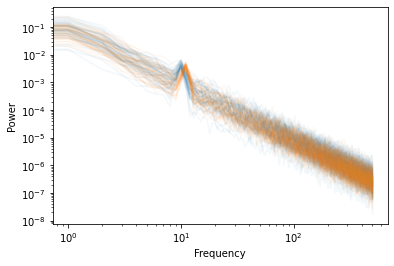

In [3]:
# Plot true classes
for powers in wf.y_array[::2]:
    plt.loglog(powers, color='C0', alpha=.05)
    
for powers in wf.y_array[1::2]:
    plt.loglog(powers, color='C1', alpha=.05)
    
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

## SVC
The support vector classifier and hyperparameters (cost and gamma) are defined below. The grid search object is what the workflow will pass the above power arrays to.

In [4]:
# Define scikit-learn grid search model hyperparameters
param_grid = dict(gamma=np.logspace(-9, 3, 13),
                  C=np.logspace(-2, 10, 13))

# Cross-validation paradigm
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
model = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

# Fit the CV model
wf.fit(model, labels)
wf.run()

# Extract balanced accuracy metric from each fold in the CV
scores = wf.results.cv_results_['mean_test_score'].reshape(13, 13)

## Results

Below shows the ranges of cost and gamma that yield the best optimized cross-validated balanced accuracy.

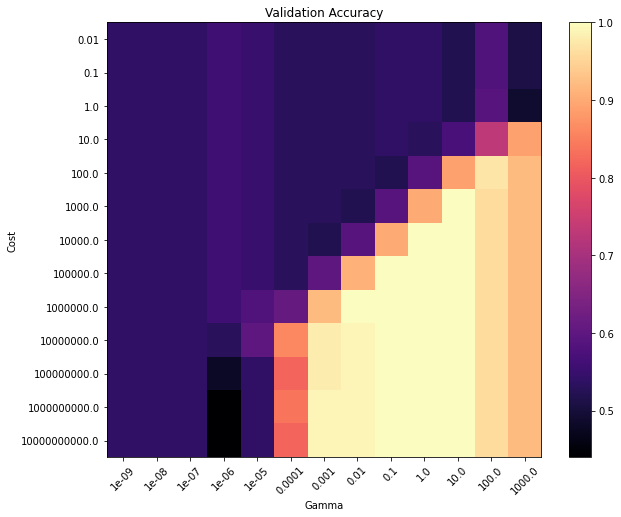

In [5]:
# Plot the grid search results
plt.figure(figsize=(10, 8))

plt.imshow(scores, interpolation="nearest", cmap=plt.cm.magma)
plt.xlabel("Gamma")
plt.ylabel("Cost")
plt.colorbar()

plt.xticks(np.arange(13), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(13), param_grid['C'])

plt.title("Validation Accuracy")
plt.show()